### CMB Assigment 2 Program ###

In [109]:
# Program, run imports
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import seaborn as sns
sns.set(style="darkgrid")

Create Pandas Dataframe

In [110]:
df = pd.read_csv("data/21-12-23_complete.csv")
#df = pd.read_csv("data/2022-01-04_complete.csv")
df.head()
# ['No.', 'Time', 'Source', 'Destination', 'Protocol', 'Length', 'Info', 'dst port']


,No.,Time,Source,Destination,Protocol,Length,Info,dst port
0,1,"2021-12-23 01:10:58,599064",2003:c1:3712:ac00:e228:6dff:fe67:1d98,2003:c1:3712:ac00:ba27:ebff:fe98:7cbe,TCP,94,41661 > 80 [SYN] Seq=0 Win=28640 Len=0 MSS=1...,1
1,2,"2021-12-23 01:10:58,603258",192.168.178.1,192.168.178.63,TCP,74,34031 > 80 [SYN] Seq=0 Win=29200 Len=0 MSS=1...,2
2,3,"2021-12-23 01:11:48,321949",192.168.178.21,192.168.178.1,DNS,102,Standard query 0x736e A epdg.epc.mnc002.mcc262...,3
3,4,"2021-12-23 01:11:48,338343",192.168.178.1,192.168.178.21,DNS,176,Standard query response 0x736e A epdg.epc.mnc0...,4
4,5,"2021-12-23 01:11:56,374062",192.168.178.1,192.168.178.21,TCP,74,46251 > 80 [SYN] Seq=0 Win=29200 Len=0 MSS=1...,5


In [111]:
# helper functions
def utcEntryToTimestamp(entry):
    row_entry = entry.split(",")[0]
    TIME_FORMAT='%Y-%m-%d %H:%M:%S'
    ts = int(datetime.strptime(row_entry, TIME_FORMAT).timestamp())
    return ts

def utcRowToTimestamp(row):
    return utcEntryToTimestamp(row.at['Time'])
utcRowToTimestamp(df.loc[0])
# print(df.loc[0].at['Time'])

1640218258

### Protocol packet distribution ###

Protocol
DNS         2117
HTTP          12
QUIC         982
SSL          265
TCP        81563
TLSv1          6
TLSv1.2    10138
TLSv1.3       17
Name: Source, dtype: int64


C:\Users\maxim\AppData\Local\Temp/ipykernel_18424/3402156693.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


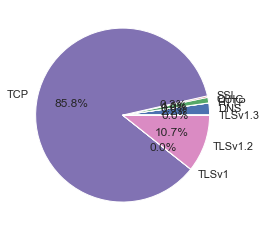

In [112]:
print(df.groupby('Protocol').Source.count())

count_protocol_packets = df.groupby('Protocol').Source.count()

fig, ax = plt.subplots()
ax.pie(count_protocol_packets, labels=count_protocol_packets.keys(), autopct='%1.1f%%',)
fig.show()

### Amount of data traffic per protocol ###

Protocol
DNS          237177
HTTP           3346
QUIC         482067
SSL          188090
TCP        28491431
TLSv1          2824
TLSv1.2     7141682
TLSv1.3        5404
Name: Length, dtype: int64


C:\Users\maxim\AppData\Local\Temp/ipykernel_18424/3990807777.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


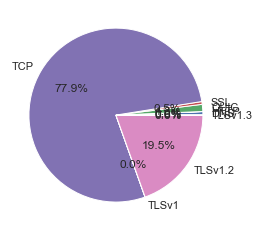

In [113]:
count_protocol_traffic = df.groupby('Protocol').Length.sum()
print(count_protocol_traffic)
fig, ax = plt.subplots()
ax.pie(count_protocol_traffic, labels=count_protocol_traffic.keys(), autopct='%1.1f%%',)
fig.show()

### Average Data length per packet ###

Protocol
DNS        112.034483
HTTP       278.833333
QUIC       490.903259
SSL        709.773585
TCP        349.318085
TLSv1      470.666667
TLSv1.2    704.446834
TLSv1.3    317.882353
Name: Length, dtype: float64

C:\Users\maxim\AppData\Local\Temp/ipykernel_18424/3215549809.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


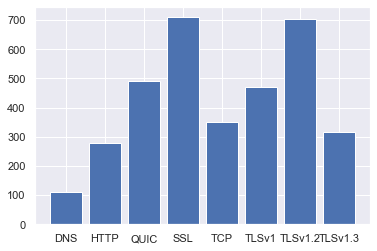

In [114]:
average_protocol_packet_length = df.groupby('Protocol').Length.sum() / df.groupby('Protocol').Length.count()
print(average_protocol_packet_length)
fig, ax = plt.subplots()
ax.bar(average_protocol_packet_length.keys(), average_protocol_packet_length)
fig.show()

### Source addresses ###

In [115]:
print(df.groupby('Source').Time.count())
print(df.groupby('Destination').Time.count())

Source
192.168.178.1                             1492
192.168.178.21                           93354
192.168.178.63                               4
195.54.160.149                               2
2003:c1:3712:ac00:e228:6dff:fe67:1d98      241
61.219.11.151                                1
8.8.8.8                                      6
Name: Time, dtype: int64
Destination
104.208.16.88     34
104.212.67.234    28
110.234.246.33    15
125.209.252.18    12
129.187.125.57    47
                  ..
99.84.82.80       29
99.84.82.84       37
99.84.82.90       62
99.84.82.94       33
99.84.85.10       14
Name: Time, Length: 209, dtype: int64


### DNS requests ###

In [116]:
df_dns = df[df['Protocol'].isin(['DNS'])]
df_dns.head()
df_dns_requests_1 = df_dns[df_dns['Info'].str.contains('Standard query')]
# does not contain response
df_dns_requests_2 = df_dns_requests_1[~df_dns_requests_1['Info'].str.contains('response')]
df_dns_resources = df_dns_requests_2['Info'].apply(lambda x: x.split(' ')[-1]).value_counts()
print(df_dns_resources)
# print(df_dns_requests)
# print(df_dns['Info'])


oauth.reddit.com                                                            87
e.reddit.com                                                                84
i.redd.it                                                                   59
alb.reddit.com                                                              55
gql.reddit.com                                                              49
                                                                            ..
cdn.optimizely.com                                                           1
mads-eu.amazon.com                                                           1
android.prod.ftl.netflix.com                                                 1
reiseauskunft.bahn.de                                                        1
e.b.c.7.8.9.e.f.f.f.b.e.7.2.a.b.0.0.0.0.0.0.0.0.0.0.0.0.0.8.e.f.ip6.arpa     1
Name: Info, Length: 173, dtype: int64


### Data traffic over time ###

2021-12-23 00:00:00
[5.0000e+00 1.5100e+02 1.2000e+01 1.3000e+01 4.7000e+01 3.6300e+02
 3.5000e+01 2.9000e+01 1.1000e+01 2.6000e+01 1.2000e+01 1.3000e+01
 1.8373e+04 2.5000e+01 1.4000e+01 1.1000e+01 1.1000e+01 2.6000e+01
 2.2500e+02 2.7000e+01 2.4000e+01 2.4000e+01 1.4000e+01 3.1000e+01
 4.6900e+02 1.1000e+01 1.7000e+01 1.1000e+01 2.6600e+03 2.1700e+02
 1.7781e+04 1.2392e+04 8.7500e+02 1.7000e+02 5.4040e+03 1.2200e+02
 7.2500e+03 3.0000e+01 1.2200e+02 9.7300e+02 2.4600e+02 3.6300e+02
 2.1500e+02 4.9170e+03 8.9900e+03 1.2400e+02 1.0231e+04 2.6000e+01
 1.1200e+02 6.4000e+01 5.3700e+02 1.8000e+02 8.1300e+02 5.0000e+00
 9.0000e+00 4.0000e+00 8.0000e+00 4.0000e+00 6.0000e+00 4.0000e+00
 7.0000e+00 4.0000e+00 8.0000e+00 5.0000e+00 6.0000e+00 4.0000e+00
 5.0000e+00 4.0000e+00 8.0000e+00 5.0000e+00 5.0000e+00 7.0000e+00
 4.0000e+00 4.0000e+00 7.0000e+00 4.0000e+00 6.0000e+00 8.0000e+00
 5.0000e+00 5.0000e+00 7.0000e+00 6.0000e+00 4.0000e+00 7.0000e+00
 4.0000e+00 8.0000e+00 4.0000e+00 5.0000e+

C:\Users\maxim\AppData\Local\Temp/ipykernel_18424/3181078928.py:43: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\maxim\AppData\Local\Temp/ipykernel_18424/3181078928.py:51: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


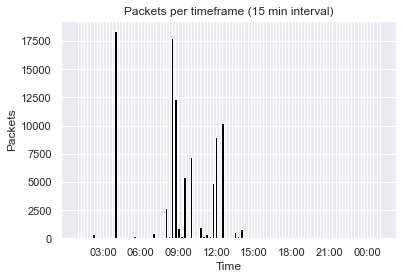

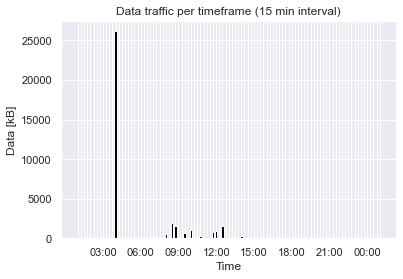

In [117]:
def timeMapping(x):
    # include time difference UTC+1
    time = datetime.utcfromtimestamp(x*min_15_duration + 3600)
    if time.minute == 0 and time.hour % 3 == 0:
        return time.strftime("%H:%M")
    else:
        return ""

# find first and last timestamp, then create data structure
min_15_duration = 60 * 15
df_time_mod = df.copy()
df_time_mod['Time'] = df_time_mod['Time'].apply(lambda x: utcEntryToTimestamp(x)) # map to 15 min window
df_time_mod.head()
first_entry = df_time_mod.loc[0].at['Time'] // min_15_duration
last_entry = df_time_mod.iloc[-1].at['Time'] // min_15_duration


offset = first_entry
count_packets = np.zeros(last_entry - first_entry + 1)
length_packets = np.zeros(last_entry - first_entry + 1)
print(datetime.utcfromtimestamp(offset * min_15_duration))
x_values_packets = list(range(offset, last_entry + 1))

mapping_res = list(map(timeMapping, x_values_packets))

# print(mapping_res)

for index, row in df_time_mod.iterrows():
    ts = row.at['Time'] // min_15_duration
    count_packets[ts - offset] += 1
    length_packets[ts - offset] += row.at['Length']

length_packets = length_packets // 1000
print(count_packets)
print(length_packets)

fig, ax = plt.subplots()
plt.xlabel('Time')
plt.ylabel('Packets')
plt.title('Packets per timeframe (15 min interval)')
plt.xticks(x_values_packets, mapping_res)
ax.bar(x_values_packets, count_packets, color='black')
fig.show()

fig, ax = plt.subplots()
plt.xlabel('Time')
plt.ylabel('Data [kB]')
plt.title('Data traffic per timeframe (15 min interval)')
plt.xticks(x_values_packets, mapping_res)
ax.bar(x_values_packets, length_packets, color='black')
fig.show()